## Constant from IV-characteristics : <font color = 'sky blue'> $n_e, T_e, T_-, I_{sat+}$ </font>
<font size="2">
    We use classical Langmuir probe method here to obtain constants listed above. <br><br>
    $n_e=\frac{I(V_p)}{eA} (\frac{2\pi m_e}{T_e})^{1/2} $ <br><br>
    $I(V_p)$ is probe current at plasma potential, $A$ is probe surface area.<br><br>
    $T_e = \frac{4\sqrt{2m_e/e}}{3n_eA} \int_{0}^{-\infty} I''(V) {|V|}^{3/2} dV$ <br><br>
    We can get $I''(V)$ from second derivative and $I_{sat+}$ from most negative probe potential. $T_-$ would be given value. <br><br>
    
</font>

In [1]:
import numpy as np
from scipy.optimize import fsolve

### Physical constant ###
e = 1.6e-19 #electron charge [C]
mp = 1 #mass of positive ion [kg]
mn = 1 #mass of negative ion [kg]
h_r = 0.6
    
### Constant from IV-characterstics ###
ne  = 1 # Electron density [#/m3]
Te = 5  # Electron temperature [eV]
Tm = 1  # Negative ion temperature [eV]
Isatp = 4 # Positive ion saturation current [A]


## Iteration method : <font color = 'purple'> </font>
<font size = '2'>
    Initial value : <font color = 'sky blue'> $\alpha_{0,0} = 2, r_{sh,0} = 0$ </font><br><br>
    Constant value : <font color = 'sky blue'> $n_e, T_e, T_-, I_{sat+}, h_r$ </font><br><br>
    We can also define $\alpha_{s,0}$ by relation between $\alpha_0$ and $\alpha_s$<br><br>
    Update modified Bohm speed : $u_{B+,k}^* = \sqrt{\frac{e T_e}{m_+}}\sqrt{\frac{1+\alpha_{s,k-1}}{1+\gamma \alpha_{s,k-1}}}$<br><br>
    Update ion density : $n_{+,k} = \frac{I_{sat+}}{h_r S_{eff,k-1}e u_{B+,k}^*}$ (Bohm flux) <br><br>
    Update electronegativity : $\alpha_{0,k} = \frac{n_{+,k}}{n_e}-1$ <br><br>
    Update $\alpha_{s,k}$ : $\alpha_{0,k} = \alpha_{s,k} exp(-\frac{1}{2} (\frac{1+\alpha_{s,k}}{1+\gamma \alpha_{s,k}})(1-\gamma))$<br><br>
    Update positive ion current density : $J_{+,k} = h_r e n_{+,k}u_{B+,k}^*$ <br><br>
    Update $r_{sh}$ : $\frac{du}{dr} = \frac{eE}{m_+u(r)}, \frac{dE}{dr} = \frac{r_{sh}J_0}{r\epsilon_0u(r)}-\frac{E}{r}$ <br><br>
    Update effective ion collecting area : $S_{eff,k} = 2\pi s_k l$ where $s_k = r_{sh,k} + a $<br><br> 
    From this point, all values are re-injected to Modified Bohm speed equation for new iteration. <br><br>
    Iteration is stopped when $|\alpha_{0,k-1}-\alpha_{0,k}|<0.01\alpha_{0,k}$ <br><br>
    $S_{eff}(V) = 2\pi l r_{sh}(V) + 2\pi r_{sh}^2(V)$ <br><br>
</font>

In [11]:
class iter_method:
    def __init__(self, ne, Te, Tm, Isatp):
        self.ne = ne 
        self.Te = Te 
        self.Tm = Tm 
        self.Isatp = Isatp
        self.gamma = Te/Tm
        self.a_0 = 2
        
    def alpha_calculation(self,a_0):
        func = lambda a_s : a_0-a_s*np.exp(-0.5*((1+a_s)/(1+self.gamma*a_s))*(1-self.gamma))
        init_a_s = [1e-5,1e-4,1e-3,1e-2,1e-1,1,1e1,1e2]
        return max(np.unique(np.round(fsolve(func, init_a_s),12))) #choose max value (need to determine what value we choose)
    
    def r_sh_calculation(self,J_k):
        return r_shk
    
    def iteration(self):
        a_0k1 = self.a_0+2 #for passing through first iteration
        a_0k2 = self.a_0
        iter_count = 0
        probe_radius = 2e-3 #diameter = 4 [mm]
        probe_length = 10e-3 #length = 10 [mm]
        
        r_shk = 0 #initial sheath size
        S_eff = 2*np.pi*(probe_radius+r_sh0)*probe_length #initial S_eff
        self.a_s = self.alpha_calculation(a_0k1)
        self.a_s = max(self.a_s) #initial a_s
        
        while(True): 
            if (abs(a_0k1-a_0k2) < 0.01*a_0k1): #iteration stop condition
                print('iteration complete!')
                break
            iter_count += 1
            a_0k1 = a_0k2
            u_Bk = np.sqrt(e*self.Te/mp)*np.sqrt((1+self.a_s)/(1+self.gamma*self.a_s)) #update u_Bk
            n_k = self.Isatp/(h_r*S_eff*u_Bk) #update n_k
            a_0k2 = n_k/ne-1 #update a_0k
            J_k = h_r*e*n_k*u_Bk #calculate J_k
            r_shk = self.r_sh_calculation(J_k) #J_k 이용한 r_shk 업데이트 식임 (r_sh_calculation 작업필요)
            S_eff = 2*np.pi*(probe_radius+r_shk)*probe_length #update S_eff
            self.a_s = self.alpha_calculation(a_0k1) #update a_sk
            print('iteration : ', iter_count)
        

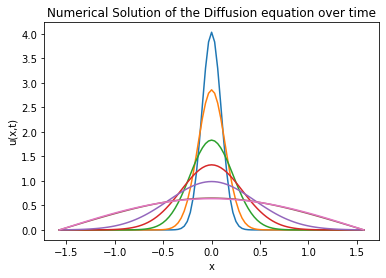

In [3]:
import numpy as np
import matplotlib.pyplot as plt

L=np.pi # value chosen for the critical length
s=101 # number of steps in x
t=10002 # number of timesteps
ds=L/(s-1) # step in x
dt=0.0001 # time step
D=1 # diffusion constant, set equal to 1
C=1 # creation rate of neutrons, set equal to 1
Alpha=(D*dt)/(ds*ds) # constant for diffusion term
Beta=C*dt # constant for u term

x = np.linspace(-L/2, 0, num=51)
x = np.concatenate([x, np.linspace(x[-1] - x[-2], L/2, num=50)]) # setting x in the specified interval
u=np.zeros(shape=(s,t)) #setting the function u
u[50,0]=1/ds # delta function
for k in range(0,t-1):
    u[0,k]=0 # boundary conditions
    u[s-1,k]=0
    for i in range(1,s-1):
        u[i,k+1]=(1+Beta-2*Alpha)*u[i,k]+Alpha*u[i+1,k]+Alpha*u[i-1,k] # numerical solution  
    if k == 50 or k == 100 or k == 250 or k == 500 or k == 1000 or k==5000 or k == 10000: # plotting at times
        plt.plot(x,u[:,k])

plt.title('Numerical Solution of the Diffusion equation over time')
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.show()
